In [ ]:
# Import main libraries
import librosa
import numpy as np
import pandas as pd
import librosa.display
import matplotlib.pyplot as plt
import keras
import soundfile as sf
import csv

In [1]:
# Set seed for reproducible results
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)

In [2]:
# import plotting functions from Plotting.py
from Plotting9 import *

In [21]:
# import metadata csv with all file names and related species
metadata=pd.read_csv("C:\\Users\\dario\\OneDrive\\Documenti\\Thesis_PC\\metadata.csv")
metadata.head()

,id,species
0,Chorthippus biguttulus (1).wav,Chorthippus biguttulus
1,Chorthippus biguttulus (2).wav,Chorthippus biguttulus
2,Chorthippus biguttulus (3).wav,Chorthippus biguttulus
3,Chorthippus biguttulus (4).wav,Chorthippus biguttulus
4,Chorthippus biguttulus (5).wav,Chorthippus biguttulus


In [4]:
# Extend audio if duration < 5 seconds
path = "C:\\Users\\dario\\OneDrive\\Documenti\\Thesis_PC\\orthoptera\\all_recordings\\"

for aud in metadata["id"]:
    dur = librosa.get_duration(filename=path+aud)
    y, sr = librosa.load(path+aud, sr = None)
    if dur >= 5:
        sf.write('resized16\\'+aud, y , sr, 'PCM_16')
    else:
        new = np.tile(y,5)
        sf.write('resized16\\'+aud, new , sr, 'PCM_16')

In [22]:
# Encode species column to 0-8
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
metadata['species'] = encoder.fit_transform(metadata['species'])
metadata.head()

,id,species
0,Chorthippus biguttulus (1).wav,0
1,Chorthippus biguttulus (2).wav,0
2,Chorthippus biguttulus (3).wav,0
3,Chorthippus biguttulus (4).wav,0
4,Chorthippus biguttulus (5).wav,0


In [6]:
# create dataset with duration = 5 to get same size

D = [] # Dataset

for row in metadata.itertuples():
    y, sr = librosa.load("C:\\Users\\dario\\OneDrive\\Documenti\\Thesis_PC\\resized16\\" + row.id, duration = 5, sr = 44100)  
    ps = librosa.feature.melspectrogram(y=y, sr=sr) ####
    db = librosa.power_to_db(ps, ref=np.max)
    if ps.shape != (128, 431): continue
    D.append( (db, row.species) )

In [7]:
print("number of wav: ", len(D))
print("sample rate of wav: ", sr)
print("shape of CNN input: ", db.shape)

number of wav:  158
sample rate of wav:  44100
shape of CNN input:  (128, 431)


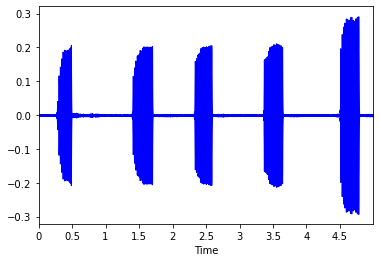

In [8]:
# Example of audio
y, sr = librosa.load("C:\\Users\\dario\\OneDrive\\Documenti\\Thesis_PC\\resized16\\Oecanthus pellucens (8).wav", sr= 44100, duration = 5)
plt.figure()
librosa.display.waveplot(y, sr, color='blue')

44100


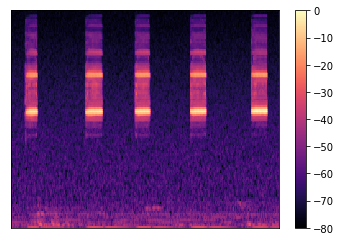

In [9]:
# Example of mel spectrogram

ps = librosa.feature.melspectrogram(y=y, sr=sr)
db = librosa.power_to_db(ps, ref=np.max)
plt.figure()
librosa.display.specshow(db)
plt.colorbar()
print(sr)

In [8]:
# Prepare data for cross validation

import random
dataset = D
random.Random(100).shuffle(dataset)

train = dataset

X, y = zip(*train)

# Reshape for CNN input
X = np.array([x.reshape( (128, 431, 1) ) for x in X])

# One-Hot encoding for classes
y = np.array(keras.utils.np_utils.to_categorical(y, 9))

In [9]:
len(D)

158

### Baseline Model

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras import layers
from keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import KFold
from keras.layers import Lambda
import keras.backend as K

In [3]:
def build_clf(optimizer = "adam", kernel_regularizer=l2(0.001)):
  # creating the layers of the NN
    model = Sequential()
    model.add(layers.Input((128,431, 1)))
    model.add(layers.Conv2D(2, (3, 3), kernel_regularizer=kernel_regularizer, activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv2D(4, (3, 3), kernel_regularizer=kernel_regularizer, activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv2D(8, (3, 3), kernel_regularizer=kernel_regularizer, activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(16, kernel_regularizer=kernel_regularizer))
    model.add(layers.Dropout(0.5))
    model.add(Dense(9, activation='softmax'))
    
    model.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"])

    return model

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
batch_size = 5
epochs = 30
modello = KerasClassifier(build_fn=build_clf, epochs=epochs, batch_size=batch_size, verbose=1)

In [ ]:
from sklearn.model_selection import GridSearchCV

optimizer= ["adam","RMsprop"]
kernel_regularizer = [l2(0.001), l2(0.01)]
params = dict(optimizer=optimizer, kernel_regularizer = kernel_regularizer)
gs=GridSearchCV(estimator=modello, param_grid=params, cv=5)
# now fit the dataset to the GridSearchCV object. 
gs = gs.fit(X, y)

In [ ]:
best_params=gs.best_params_
accuracy=gs.best_score_
print(best_params)
print(accuracy)

In [11]:
# Define the K-fold Cross Validator
kfold =  KFold(n_splits = 5, shuffle=True, random_state = 15)
acc_per_fold = []
loss_per_fold = []
accuracy_fold = []
predicted_targets = np.array([])
actual_targets = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X,y):

  # Define the model architecture
    model = Sequential()
    model.add(layers.Input((128,431, 1)))
    model.add(layers.Conv2D(2, (3, 3), kernel_regularizer=l2(0.001), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv2D(4, (3, 3), kernel_regularizer=l2(0.001), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv2D(8, (3, 3), kernel_regularizer=l2(0.001), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(16, kernel_regularizer=l2(0.001)))
    model.add(layers.Dropout(0.5))
    model.add(Dense(16, kernel_regularizer=l2(0.001)))
    model.add(Dense(9, activation='softmax'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
  # Compile the model
    model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])


  # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

  # Fit data to model
    history = model.fit(X[train], y[train],
              batch_size=5,
              epochs=30, # deve essere 30
              verbose=1)
   
    accuracy_fold.append(history)
    
  # Generate generalization metrics
    scores = model.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    
    print(len(X[train]), len(y[train]))
    print(len(X[test]), len(y[test]))

    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    predict = model.predict(X[test])
    predicted_labels = predict.argmax(axis=1)
    predicted_targets = np.append(predicted_targets, predicted_labels)
    
    actual_labels = y[test].argmax(axis=1)
    actual_targets = np.append(actual_targets, actual_labels)
    
  # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30
26/26 [==============================] - 2s 36ms/step - loss: 3.8773 - accuracy: 0.1984
Epoch 2/30
26/26 [==============================] - 1s 37ms/step - loss: 1.8889 - accuracy: 0.3571
Epoch 3/30
26/26 [==============================] - 2s 91ms/step - loss: 1.6459 - accuracy: 0.4683
Epoch 4/30
26/26 [==============================] - 5s 166ms/step - loss: 1.4593 - accuracy: 0.5000
Epoch 5/30
26/26 [==============================] - 1s 41ms/step - loss: 1.4178 - accuracy: 0.5159
Epoch 6/30
26/26 [==============================] - 1s 37ms/step - loss: 1.3952 - accuracy: 0.5079
Epoch 7/30
26/26 [==============================] - 1s 37ms/step - loss: 1.1354 - accuracy: 0.6111
Epoch 8/30
26/26 [==============================] - 1s 37ms/step - loss: 1.1622 - accuracy: 0.6270
Epoch 9/30
26/26 [==============================] - 1s 38ms/step - loss: 1.1355 - accuracy: 0.6111
Epoch 10/30

In [12]:
# Accuracy with standard deviation of cross validation
print("%.2f%% (+/- %.2f%%)" % (np.mean(acc_per_fold), np.std(acc_per_fold)))

52.58% (+/- 7.38%)


Confusion matrix, without normalization


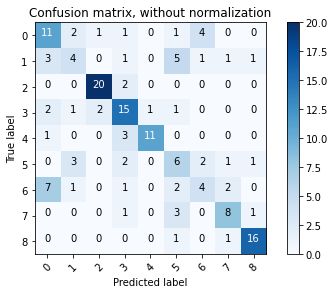

Normalized confusion matrix


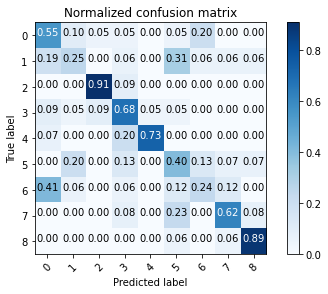

In [15]:
plot_confusion_matrix(predicted_targets, actual_targets)

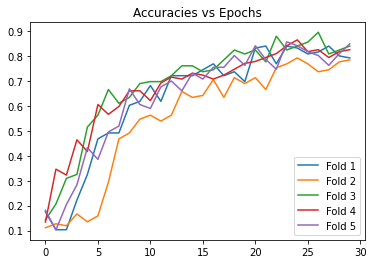

In [16]:
accuracies (5, accuracy_fold)

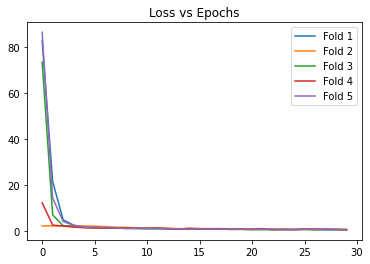

In [17]:
## function from plotting.py
errors (folds = 5, accuracies = accuracy_fold)

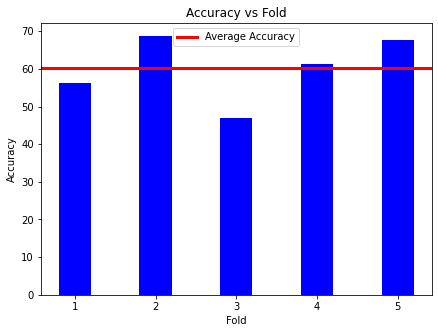

In [18]:
# function from plotting.py
avg_acc([1,2,3,4,5], acc_per_fold)

### Data Augmentation

In [95]:
# array to append all wav names and species and to store it in a csv
data = []

In [96]:
# copy audio in augmentation folder

for row in metadata.itertuples():
    y, sr = librosa.load("C:\\Users\\dario\\OneDrive\\Documenti\\Thesis_PC\\resized16\\" + row.id, duration = 5, sr = None) 
    sf.write("C:\\Users\\dario\\OneDrive\\Documenti\\Thesis_PC\\augmentation\\" + row.id, y, sr)
    data.append([row.id,row.species])

In [97]:
# time_stretch: If rate > 1, then the signal is sped up. If rate < 1, then the signal is slowed down

rate = [0.80, 0.90]
for r in rate:
    for row in metadata.itertuples():
        y, sr = librosa.load("C:\\Users\\dario\\OneDrive\\Documenti\\Thesis_PC\\resized16\\" + row.id, duration = 5, sr = None) 
        y_changed = librosa.effects.time_stretch(y, rate=r)
        sf.write("C:\\Users\\dario\\OneDrive\\Documenti\\Thesis_PC\\augmentation\\" + "Aug_" + row.id, y_changed, sr)
        data.append( ["Aug_" + row.id, row.species])

In [98]:
# Pitch shift
n_steps = [-1, 1, 2]
for s in n_steps:
    for row in metadata.itertuples():
        y, sr = librosa.load("C:\\Users\\dario\\OneDrive\\Documenti\\Thesis_PC\\resized16\\" + row.id, duration = 5, sr = None) 
        y_changed = librosa.effects.pitch_shift(y, sr, n_steps=s)
        sf.write("C:\\Users\\dario\\OneDrive\\Documenti\\Thesis_PC\\augmentation\\" + "Aug_7" + row.id, y_changed, sr)
        data.append( ["Aug_7" + row.id, row.species])

In [99]:
# Time shift
shift_max = 0.2

for row in metadata.itertuples():
    y, sr = librosa.load("C:\\Users\\dario\\OneDrive\\Documenti\\Thesis_PC\\resized16\\" + row.id, duration = 5, sr = None) 
    shift = np.random.randint(sr * shift_max)
    shift = -shift
    y_changed = np.roll(y, shift)
    # Set to silence for heading/ tailing
    if shift > 0:
        y_changed[:shift] = 0
    else:
        y_changed[shift:] = 0
    sf.write("C:\\Users\\dario\\OneDrive\\Documenti\\Thesis_PC\\augmentation\\" + "Aug_4" + row.id, y_changed, sr)
    data.append( ["Aug_4" + row.id, row.species])

#### Add background noise + data augmentation

In [101]:
# set up Environmental background noise
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, AddBackgroundNoise

augment = Compose([
    AddBackgroundNoise(sounds_path ="C:\\Users\\dario\\OneDrive\\Documenti\\Thesis_PC\\audio\\", 
        min_snr_in_db=3,
        max_snr_in_db=40, p = 1)
])

In [102]:
# Add Background Noise to original wav

data_noise = []
for row in metadata.itertuples():
    y, sr = librosa.load("C:\\Users\\dario\\OneDrive\\Documenti\\Thesis_PC\\resized16\\" + row.id, duration = 5, sr = 44100) 
    y_changed = augment(samples=y, sample_rate=44100)
    sf.write("C:\\Users\\dario\\OneDrive\\Documenti\\Thesis_PC\\augmentation\\" + "Aug_6" + row.id, y_changed, sr)
    data_noise.append( ["Aug_6" + row.id, row.species])
    data.append( ["Aug_6" + row.id, row.species])

In [103]:
# save augmented to metadata_augmented csv

header = ["id", "species"]
with open(r"C:\Users\dario\OneDrive\Documenti\Thesis_PC\orthoptera\metadata_noise.csv", 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(data_noise)

In [104]:
# import metadata csv with all file names and related species

noise=pd.read_csv("C:\\Users\\dario\\OneDrive\\Documenti\\Thesis_PC\\orthoptera\\metadata_noise.csv")
noise.tail()

,id,species
153,Aug_6Tettigonia viridissima (14).wav,8
154,Aug_6Tettigonia viridissima (15).wav,8
155,Aug_6Tettigonia viridissima (16).wav,8
156,Aug_6Tettigonia viridissima (17).wav,8
157,Aug_6Tettigonia viridissima (18).wav,8


In [ ]:
# Time stretch on noised data

rate = 0.80

for row in noise.itertuples():
    y, sr = librosa.load("C:\\Users\\dario\\OneDrive\\Documenti\\Thesis_PC\\augmentation\\" + row.id, duration = 5, sr = None) 
    y_changed = librosa.effects.time_stretch(y, rate=rate)
    sf.write("C:\\Users\\dario\\OneDrive\\Documenti\\Thesis_PC\\augmentation\\" + "Aug_5" + row.id, y_changed, sr)
    data.append( ["Aug_5" + row.id, row.species])

In [ ]:
len(data)

1422

In [33]:
# save augmented to metadata_augmented csv

header = ["id", "species"]
with open(r"C:\Users\dario\OneDrive\Documenti\Thesis_PC\orthoptera\metadata_augmented.csv", 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(data)

In [34]:
# Read augmentation csv

metadata_aug=pd.read_csv("C:\\Users\\dario\\OneDrive\\Documenti\\Thesis_PC\\orthoptera\\metadata_augmented.csv")
metadata_aug.tail()

,id,species
1417,Aug_5Aug_6Tettigonia viridissima (14).wav,8
1418,Aug_5Aug_6Tettigonia viridissima (15).wav,8
1419,Aug_5Aug_6Tettigonia viridissima (16).wav,8
1420,Aug_5Aug_6Tettigonia viridissima (17).wav,8
1421,Aug_5Aug_6Tettigonia viridissima (18).wav,8


In [35]:
# create dataset with duration = 5 to get same size

D = [] # Dataset

for row in metadata_aug.itertuples():
    y, sr = librosa.load("C:\\Users\\dario\\OneDrive\\Documenti\\Thesis_PC\\augmentation\\" + row.id, duration = 5, sr = 44100)  
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    db = librosa.power_to_db(ps, ref=np.max)
    if db.shape != (128, 431): continue 
    D.append( (db, row.species) )


In [36]:
print("number of wav: ", len(D))
print("sample rate of wav: ", sr)
print("shape of CNN input: ", db.shape)

number of wav:  1422
sample rate of wav:  44100
shape of CNN input:  (128, 431)


In [37]:
# Prepare data for cross validation

import random
dataset = D
random.Random(100).shuffle(dataset)

train = dataset

X, y = zip(*train)

# Reshape for CNN input
X = np.array([x.reshape( (128, 431, 1) ) for x in X])

# One-Hot encoding for classes
y = np.array(keras.utils.np_utils.to_categorical(y, 9))

In [ ]:
def build_clf(optimizer = "adam", kernel_regularizer=l2(0.001)):
  # creating the layers of the NN
    model = Sequential()
    model.add(layers.Input((128, 431, 1)))
    model.add(layers.Conv2D(filters=8, kernel_size=(3, 3), kernel_regularizer=kernel_regularizer, activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), kernel_regularizer=kernel_regularizer, activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), kernel_regularizer=kernel_regularizer, activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), kernel_regularizer=kernel_regularizer, activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Dense(9, activation='softmax'))
    model.compile(optimizer=optimizer, loss="categorical_crossentropy",metrics=["accuracy"])
    return model

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
batch_size = 5
epochs = 10
modello = KerasClassifier(build_fn=build_clf, epochs=epochs, batch_size=batch_size, verbose=1)

In [ ]:
from sklearn.model_selection import GridSearchCV
kernel_regularizer=[l2(0.1),l2(0.01),l2(0.001)]
optimizer= ["adam","RMsprop"]
params = dict(optimizer=optimizer, kernel_regularizer=kernel_regularizer)
gs=GridSearchCV(estimator=modello, param_grid=params, cv=5)
# now fit the dataset to the GridSearchCV object. 
gs = gs.fit(X, y)

In [ ]:
best_params=gs.best_params_
accuracy=gs.best_score_
print(best_params)
print(accuracy)

In [38]:
# Define the K-fold Cross Validator
kfold =  KFold(n_splits=5, shuffle=True)
acc_per_fold = []
loss_per_fold = []
accuracy_fold = []
predicted_targets = np.array([])
actual_targets = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X,y):

  # Define the model architecture
    model = Sequential()
    model.add(layers.Input((128, 431, 1)))
    model.add(layers.Conv2D(8, (3, 3), kernel_regularizer=l2(0.001), activation='relu', name='Layer_1'))
    model.add(layers.MaxPooling2D((2, 2), name='MaxPool_1'))

    model.add(layers.Conv2D(16, (3, 3), kernel_regularizer=l2(0.001), activation='relu', name='Layer_2'))
    model.add(layers.MaxPooling2D((2, 2), name='MaxPool_2'))

    model.add(layers.Conv2D(32, (3, 3), kernel_regularizer=l2(0.001), activation='relu', name='Layer_3'))
    model.add(layers.MaxPooling2D((2, 2), name='MaxPool_3'))

    model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=l2(0.001), activation='relu', name='Layer_4'))
    model.add(layers.MaxPooling2D((2, 2), name='MaxPool_4'))

    model.add(Flatten(name='Flat'))
    model.add(Dense(64, name='Layer_5'))
    model.add(Dense(9, activation='softmax', name='Output'))
    
  # Compile the model
    model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])


  # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

  # Fit data to model
    history = model.fit(X[train], y[train],
              batch_size=5,
              epochs=10,
              verbose=1)
   
    accuracy_fold.append(history)
    
  # Generate generalization metrics
    scores = model.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    predict = model.predict(X[test])
    predicted_labels = predict.argmax(axis=1)
    predicted_targets = np.append(predicted_targets, predicted_labels)
    
    actual_labels = y[test].argmax(axis=1)
    actual_targets = np.append(actual_targets, actual_labels)

  # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
228/228 [==============================] - 16s 68ms/step - loss: 2.0077 - accuracy: 0.5541
Epoch 2/10
228/228 [==============================] - 16s 70ms/step - loss: 0.8964 - accuracy: 0.7590
Epoch 3/10
228/228 [==============================] - 15s 66ms/step - loss: 0.7447 - accuracy: 0.8109
Epoch 4/10
228/228 [==============================] - 15s 67ms/step - loss: 0.4715 - accuracy: 0.8505
Epoch 5/10
228/228 [==============================] - 17s 73ms/step - loss: 0.2951 - accuracy: 0.9120
Epoch 6/10
228/228 [==============================] - 17s 73ms/step - loss: 0.2167 - accuracy: 0.9420
Epoch 7/10
228/228 [==============================] - 17s 74ms/step - loss: 0.1707 - accuracy: 0.9481
Epoch 8/10
228/228 [==============================] - 18s 80ms/step - loss: 0.0695 - accuracy: 0.9780
Epoch 9/10
228/228 [==============================] - 19s 82ms/step - loss: 0.3718 - ac

In [39]:
# Accuracy with standard deviation of cross validation
print("%.2f%% (+/- %.2f%%)" % (np.mean(acc_per_fold), np.std(acc_per_fold)))

92.05% (+/- 1.92%)


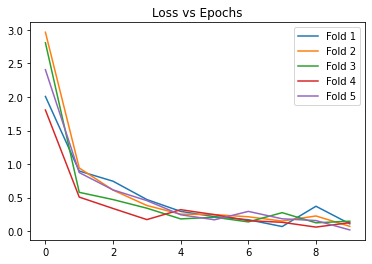

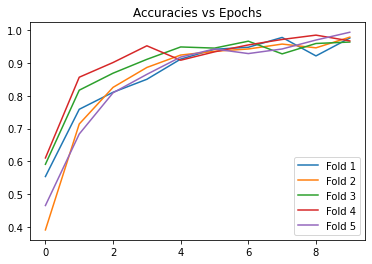

In [40]:
# Plot of k-fold accuracies
errors (5, accuracy_fold)
accuracies (5, accuracy_fold)

Confusion matrix, without normalization


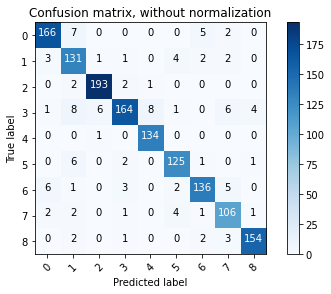

Normalized confusion matrix


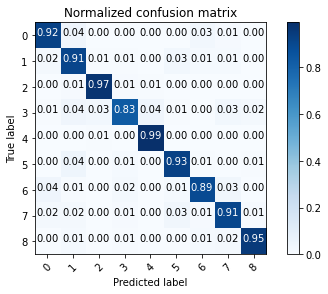

In [41]:
# COnfusion matrix
plot_confusion_matrix(predicted_targets, actual_targets)

### Tranfer Learning 158

In [3]:
# import metadata csv with all file names and related species
metadata=pd.read_csv("C:\\Users\\dario\\OneDrive\\Documenti\\Thesis_PC\\metadata.csv")
metadata.tail()

,id,species
153,Tettigonia viridissima (14).wav,Tettigonia viridissima
154,Tettigonia viridissima (15).wav,Tettigonia viridissima
155,Tettigonia viridissima (16).wav,Tettigonia viridissima
156,Tettigonia viridissima (17).wav,Tettigonia viridissima
157,Tettigonia viridissima (18).wav,Tettigonia viridissima


In [8]:
# Duration = 5 seconds
path = "C:\\Users\\dario\\OneDrive\\Documenti\\Thesis_PC\\resized16\\"

for aud in metadata["id"]:
    y, sr = librosa.load(path+aud, duration = 5, sr = None)
    sf.write('orthoptera\\transfer_learning\\'+aud, y , sr)

In [4]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

In [6]:
# Import YAMNet model from url

yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [7]:
# Load a WAV file, convert it to a float tensor, resample to 44.1 kHz single-channel audio.

def load_wav_44k_mono(filename):   
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=44100)
    return wav

In [8]:
# Categories in Audioset data

class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
    print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


In [9]:
# Load Insects data

metadata_tl= "C:\\Users\\dario\\OneDrive\\Documenti\\Thesis_PC\\metadata.csv" # orthoptera\\metadata_augmented.csv
base_data_path = "C:\\Users\\dario\\OneDrive\\Documenti\\Thesis_PC\\orthoptera\\transfer_learning\\" # \\Thesis_PC\\augmentation\\

metadata = pd.read_csv(metadata_tl)
metadata.tail()

,id,species
153,Tettigonia viridissima (14).wav,Tettigonia viridissima
154,Tettigonia viridissima (15).wav,Tettigonia viridissima
155,Tettigonia viridissima (16).wav,Tettigonia viridissima
156,Tettigonia viridissima (17).wav,Tettigonia viridissima
157,Tettigonia viridissima (18).wav,Tettigonia viridissima


In [10]:
# Encode species column to 0-8
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
metadata['species'] = encoder.fit_transform(metadata['species'])
metadata.tail()

,id,species
153,Tettigonia viridissima (14).wav,8
154,Tettigonia viridissima (15).wav,8
155,Tettigonia viridissima (16).wav,8
156,Tettigonia viridissima (17).wav,8
157,Tettigonia viridissima (18).wav,8


In [11]:
# Classes of insects data
my_classes = ["Chorthippus biguttulus",
              "Chorthippus brunneus",
              "Gryllus campestris",
              "Nemobius sylvestris",
              "Oecanthus pellucens",
              "Pholidoptera griseoaptera",
              "Pseudochorthippus parallelus" ,
              "Roeseliana roeselii",
              "Tettigonia viridissima"]

In [12]:
# Add recordings path to csv metadata

full_path = metadata['id'].apply(lambda row: os.path.join(base_data_path, row))
metadata = metadata.assign(id=full_path)

metadata.tail()

,id,species
153,C:\Users\dario\OneDrive\Documenti\Thesis_PC\or...,8
154,C:\Users\dario\OneDrive\Documenti\Thesis_PC\or...,8
155,C:\Users\dario\OneDrive\Documenti\Thesis_PC\or...,8
156,C:\Users\dario\OneDrive\Documenti\Thesis_PC\or...,8
157,C:\Users\dario\OneDrive\Documenti\Thesis_PC\or...,8


In [13]:
# Plit wav from species

filenames = metadata['id']
targets = metadata['species']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [14]:
def load_wav_for_map(filename, label):
    return load_wav_44k_mono(filename), label

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [15]:
# run YAMNet to extract embedding from the wav data

def extract_embedding(wav_data, label):
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,
            tf.repeat(label, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [16]:
# Shuffle dataset
main_ds = main_ds.cache().shuffle(1000)

# Split dataset in train, validation, test
train_ds = main_ds.shard(num_shards=3, index=0)
val_ds = main_ds.shard(num_shards=3, index=1)
test_ds = main_ds.shard(num_shards=3, index=2)

train_ds = train_ds.cache().shuffle(15).batch(5).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(5).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(5).prefetch(tf.data.AUTOTUNE)

In [17]:
# Add Dense layers on top of Yamnet

my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32, name='input_embedding'),
    tf.keras.layers.Dense(512, activation = "relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(9, activation = "softmax")
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 9)                 4617      
                                                                 
Total params: 529,417
Trainable params: 529,417
Non-trainable params: 0
_________________________________________________________________


In [18]:
my_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [19]:
# Model fit

history = my_model.fit(train_ds,
                       epochs=30,
                       validation_data=val_ds)

Epoch 1/30
295/295 [==============================] - 22s 58ms/step - loss: 1.9398 - accuracy: 0.6692 - val_loss: 1.7550 - val_accuracy: 0.5410
Epoch 2/30
295/295 [==============================] - 1s 4ms/step - loss: 0.9089 - accuracy: 0.7315 - val_loss: 1.1146 - val_accuracy: 0.6088
Epoch 3/30
295/295 [==============================] - 1s 4ms/step - loss: 0.6763 - accuracy: 0.7647 - val_loss: 1.0435 - val_accuracy: 0.6325
Epoch 4/30
295/295 [==============================] - 1s 4ms/step - loss: 0.5876 - accuracy: 0.8075 - val_loss: 0.9862 - val_accuracy: 0.6447
Epoch 5/30
295/295 [==============================] - 1s 5ms/step - loss: 0.5680 - accuracy: 0.8007 - val_loss: 0.9099 - val_accuracy: 0.6522
Epoch 6/30
295/295 [==============================] - 1s 5ms/step - loss: 0.5470 - accuracy: 0.8210 - val_loss: 0.8982 - val_accuracy: 0.6759
Epoch 7/30
295/295 [==============================] - 1s 5ms/step - loss: 0.4755 - accuracy: 0.8353 - val_loss: 0.9138 - val_accuracy: 0.6793
Epoc

In [20]:
# Evaluate TL model on test
loss, accuracy = my_model.evaluate(test_ds)

295/295 [==============================] - 1s 1ms/step - loss: 0.7929 - accuracy: 0.7788


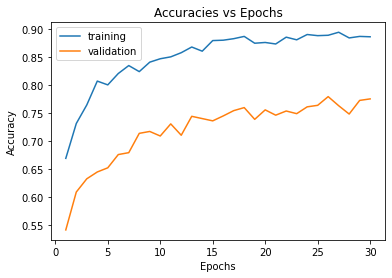

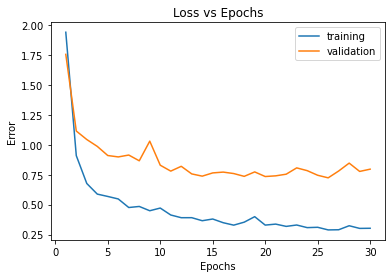

In [21]:
results(history, val_ds, my_model)

In [22]:
predicted_targets = my_model.predict(test_ds)

In [23]:
len(predicted_targets)

1474

In [24]:
# Extract true labels from tensor set (test set in this case)
def get_labels_from_tfdataset(tfdataset, batched=False):

    labels = list(map(lambda x: x[1], tfdataset)) # Get labels 

    if not batched:
        return tf.concat(labels, axis=0) # concat the list of batched labels

    return labels

In [25]:
predicted_targets = np.argmax(predicted_targets, axis =1)

Confusion matrix, without normalization


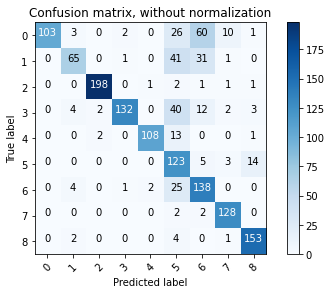

Normalized confusion matrix


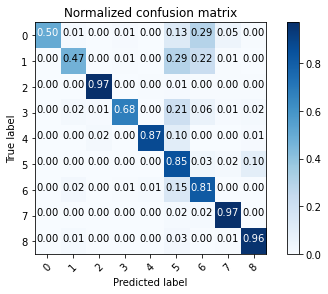

In [26]:
# Confusion matrix
plot_confusion_matrix(predicted_targets, get_labels_from_tfdataset(test_ds, batched=False))

### Transfer Learning & Augmentation Combined

In [161]:
# Import YAMNet model from url

yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [162]:
# Load Insects data

metadata_aug = "C:\\Users\\dario\\OneDrive\\Documenti\\Thesis_PC\\orthoptera\\metadata_augmented.csv" 
base_data_path = "C:\\Users\\dario\\OneDrive\\Documenti\\Thesis_PC\\augmentation\\" 

metadata = pd.read_csv(metadata_aug)
metadata.head()

,id,species
0,Chorthippus biguttulus (1).wav,0
1,Chorthippus biguttulus (2).wav,0
2,Chorthippus biguttulus (3).wav,0
3,Chorthippus biguttulus (4).wav,0
4,Chorthippus biguttulus (5).wav,0


In [163]:
# Add recordings path to csv metadata

full_path = metadata['id'].apply(lambda row: os.path.join(base_data_path, row))
metadata = metadata.assign(id=full_path)

metadata.head(100)

,id,species
0,C:\Users\dario\OneDrive\Documenti\Thesis_PC\au...,0
1,C:\Users\dario\OneDrive\Documenti\Thesis_PC\au...,0
2,C:\Users\dario\OneDrive\Documenti\Thesis_PC\au...,0
3,C:\Users\dario\OneDrive\Documenti\Thesis_PC\au...,0
4,C:\Users\dario\OneDrive\Documenti\Thesis_PC\au...,0
...,...,...
95,C:\Users\dario\OneDrive\Documenti\Thesis_PC\au...,5
96,C:\Users\dario\OneDrive\Documenti\Thesis_PC\au...,5
97,C:\Users\dario\OneDrive\Documenti\Thesis_PC\au...,5
98,C:\Users\dario\OneDrive\Documenti\Thesis_PC\au...,5


In [164]:
len(metadata)

1422

In [165]:
# Plit wav from species

filenames = metadata['id']
targets = metadata['species']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [166]:
def load_wav_for_map(filename, label):
    return load_wav_44k_mono(filename), label

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [167]:
# run YAMNet to extract embedding from the wav data

def extract_embedding(wav_data, label):
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,
            tf.repeat(label, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [168]:
# Shuffle dataset
main_ds = main_ds.cache().shuffle(1000)

# Split dataset in train, validation, test
train_ds = main_ds.shard(num_shards=3, index=0)
val_ds = main_ds.shard(num_shards=3, index=1)
test_ds = main_ds.shard(num_shards=3, index=2)

train_ds = train_ds.cache().shuffle(15).batch(5).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(5).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(5).prefetch(tf.data.AUTOTUNE)

In [169]:
# Add Dense layers on top of Yamnet

my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32, name='input_embedding'),
    tf.keras.layers.Dense(512, activation = "relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(9, activation = "softmax")
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 512)               524800    
                                                                 
 dropout_24 (Dropout)        (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 9)                 4617      
                                                                 
Total params: 529,417
Trainable params: 529,417
Non-trainable params: 0
_________________________________________________________________


In [170]:
my_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [171]:
# Model fit

history = my_model.fit(train_ds,
                       epochs=30,
                       validation_data=val_ds)

Epoch 1/30
2792/2792 [==============================] - 213s 74ms/step - loss: 1.0116 - accuracy: 0.7032 - val_loss: 1.2971 - val_accuracy: 0.5730
Epoch 2/30
2792/2792 [==============================] - 13s 5ms/step - loss: 0.7543 - accuracy: 0.7445 - val_loss: 1.1136 - val_accuracy: 0.6198
Epoch 3/30
2792/2792 [==============================] - 13s 5ms/step - loss: 0.6877 - accuracy: 0.7686 - val_loss: 1.0512 - val_accuracy: 0.6617
Epoch 4/30
2792/2792 [==============================] - 13s 5ms/step - loss: 0.6621 - accuracy: 0.7762 - val_loss: 0.9247 - val_accuracy: 0.6754
Epoch 5/30
2792/2792 [==============================] - 14s 5ms/step - loss: 0.6231 - accuracy: 0.7841 - val_loss: 0.8374 - val_accuracy: 0.6969
Epoch 6/30
2792/2792 [==============================] - 13s 5ms/step - loss: 0.6040 - accuracy: 0.7870 - val_loss: 0.8430 - val_accuracy: 0.7049
Epoch 7/30
2792/2792 [==============================] - 13s 5ms/step - loss: 0.5745 - accuracy: 0.7954 - val_loss: 1.2670 - val_

In [172]:
# Evaluate TL model on test
loss, accuracy = my_model.evaluate(test_ds)

2792/2792 [==============================] - 4s 1ms/step - loss: 0.6143 - accuracy: 0.8076


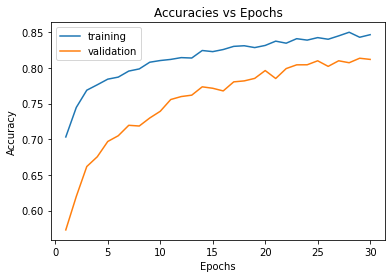

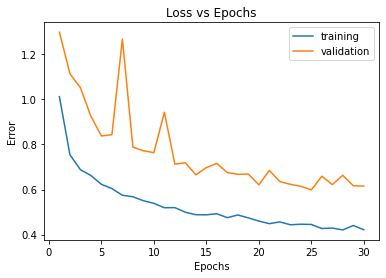

In [173]:
results(history, val_ds, my_model)

In [174]:
predicted_targets = my_model.predict(test_ds)

In [175]:
len(predicted_targets)

13956

In [176]:
predicted_targets = np.argmax(predicted_targets, axis =1)

Confusion matrix, without normalization


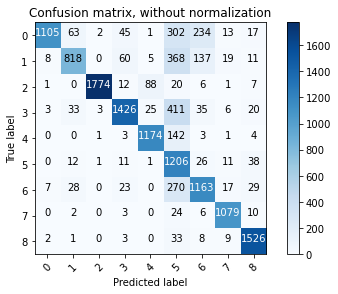

Normalized confusion matrix


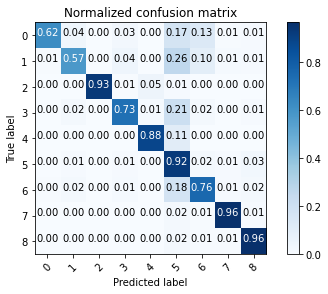

In [177]:
# Confusion matrix
plot_confusion_matrix(predicted_targets, get_labels_from_tfdataset(test_ds, batched=False))

### Raw Waveforms 158

In [10]:
# import metadata csv with all file names and related species
metadata=pd.read_csv("C:\\Users\\dario\\OneDrive\\Documenti\\Thesis_PC\\metadata.csv")
metadata.tail()

,id,species
153,Tettigonia viridissima (14).wav,Tettigonia viridissima
154,Tettigonia viridissima (15).wav,Tettigonia viridissima
155,Tettigonia viridissima (16).wav,Tettigonia viridissima
156,Tettigonia viridissima (17).wav,Tettigonia viridissima
157,Tettigonia viridissima (18).wav,Tettigonia viridissima


In [11]:
# Encode species column to 0-8
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
metadata['species'] = encoder.fit_transform(metadata['species'])
metadata.head()

,id,species
0,Chorthippus biguttulus (1).wav,0
1,Chorthippus biguttulus (2).wav,0
2,Chorthippus biguttulus (3).wav,0
3,Chorthippus biguttulus (4).wav,0
4,Chorthippus biguttulus (5).wav,0


In [12]:
# create dataset with duration = 5 to get same size

D = [] # Dataset

for row in metadata.itertuples():
    y, sr = librosa.load("C:\\Users\\dario\\OneDrive\\Documenti\\Thesis_PC\\orthoptera\\transfer_learning\\" + row.id, duration = 5, sr = 44100)  
    D.append( (y, row.species) )

In [13]:
len(D)

158

In [14]:
import random
dataset = D
random.Random(100).shuffle(dataset)

train = dataset

X, y = zip(*train)

# Reshape for CNN input
X = np.array([x.reshape( (220500, 1) ) for x in X])

# One-Hot encoding for classes
y = np.array(keras.utils.np_utils.to_categorical(y, 9))

In [184]:
def build_clf(optimizer = "adam", unit = 8):
  # creating the layers of the NN
    model = Sequential()
    model.add(layers.Input((220500, 1)))
    model.add(layers.Conv1D(filters=unit, kernel_size=5)) #, kernel_regularizer=l2(0.001)))
    model.add(Activation('relu'))

    model.add(layers.Conv1D(filters=unit, kernel_size=5)) #, kernel_regularizer=l2(0.01)))
    model.add(Activation('relu'))

    model.add(layers.Conv1D(filters=unit, kernel_size=5)) #, kernel_regularizer=l2(0.01)))
    model.add(Activation('relu'))

    model.add(layers.MaxPooling1D(2))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.MaxPooling1D(2))

    model.add(Dense(8))
    model.add(Lambda(lambda x: K.mean(x, axis=1))) # maybe change to 0
    model.add(Dense(9, activation='softmax'))
     
    model.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"])
    return model

In [185]:
from keras.wrappers.scikit_learn import KerasClassifier
batch_size = 5
epochs = 100
modello = KerasClassifier(build_fn=build_clf, epochs=epochs, batch_size=batch_size, verbose=1)

C:\Users\dario\AppData\Local\Temp/ipykernel_24544/826481813.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  modello = KerasClassifier(build_fn=build_clf, epochs=epochs, batch_size=batch_size, verbose=1)


In [ ]:
from sklearn.model_selection import GridSearchCV
units = [8,16,32]
params = dict(optimizer=optimizer unit = units)
gs=GridSearchCV(estimator=modello, param_grid=params, cv=5)
# now fit the dataset to the GridSearchCV object. 
gs = gs.fit(X, y)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 220496, 8)         48        
                                                                 
 activation (Activation)     (None, 220496, 8)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 220492, 8)         328       
                                                                 
 activation_1 (Activation)   (None, 220492, 8)         0         
                                                                 
 conv1d_2 (Conv1D)           (None, 220488, 8)         328       
                                                                 
 activation_2 (Activation)   (None, 220488, 8)         0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 110244, 8)       

In [ ]:
best_params=gs.best_params_
accuracy=gs.best_score_
print(best_params)
print(accuracy)

In [15]:
import random
from keras import utils as np_utils

dataset = D
random.Random(100).shuffle(dataset)


train = dataset[:128]
valid = dataset[128:143]
test = dataset[143:]

X_train, y_train = zip(*train)
X_valid, y_valid = zip(*valid)
X_test, y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (220500, 1) ) for x in X_train])
X_valid = np.array([x.reshape( (220500, 1) ) for x in X_valid])
X_test = np.array([x.reshape( (220500, 1) ) for x in X_test])

# One-Hot encoding for classes
y_train = np.array(keras.utils.np_utils.to_categorical(y_train, 9))
y_valid = np.array(keras.utils.np_utils.to_categorical(y_valid, 9))
y_test = np.array(keras.utils.np_utils.to_categorical(y_test, 9))

In [16]:
# model
model = Sequential()

model.add(layers.Input((220500, 1)))
model.add(layers.Conv1D(8, kernel_size=5)) #, kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
          
model.add(layers.Conv1D(16, kernel_size=5)) #, kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))

model.add(layers.MaxPooling1D(2))
model.add(layers.MaxPooling1D(2))
model.add(layers.MaxPooling1D(2))

model.add(Dense(16))
model.add(Lambda(lambda x: K.mean(x, axis=1))) # maybe change to 0
model.add(Dense(9, activation='softmax'))

model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 220496, 8)         48        
                                                                 
 activation_4 (Activation)   (None, 220496, 8)         0         
                                                                 
 conv1d_5 (Conv1D)           (None, 220492, 16)        656       
                                                                 
 activation_5 (Activation)   (None, 220492, 16)        0         
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 110246, 16)       0         
 1D)                                                             
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 55123, 16)        0         
 1D)                                                  

In [209]:
history = model.fit(X_train, y_train, batch_size=10, epochs=400, validation_data=(X_valid, y_valid), verbose=1)

Epoch 1/400
13/13 [==============================] - 12s 846ms/step - loss: 2.1964 - accuracy: 0.1094 - val_loss: 2.1857 - val_accuracy: 0.3333
Epoch 2/400
13/13 [==============================] - 11s 824ms/step - loss: 2.1927 - accuracy: 0.1328 - val_loss: 2.1803 - val_accuracy: 0.3333
Epoch 3/400
13/13 [==============================] - 11s 814ms/step - loss: 2.1901 - accuracy: 0.1641 - val_loss: 2.1730 - val_accuracy: 0.3333
Epoch 4/400
13/13 [==============================] - 11s 823ms/step - loss: 2.1867 - accuracy: 0.1953 - val_loss: 2.1658 - val_accuracy: 0.3333
Epoch 5/400
13/13 [==============================] - 11s 843ms/step - loss: 2.1833 - accuracy: 0.1719 - val_loss: 2.1530 - val_accuracy: 0.3333
Epoch 6/400
13/13 [==============================] - 11s 828ms/step - loss: 2.1783 - accuracy: 0.2031 - val_loss: 2.1429 - val_accuracy: 0.3333
Epoch 7/400
13/13 [==============================] - 11s 844ms/step - loss: 2.1730 - accuracy: 0.1953 - val_loss: 2.1260 - val_accuracy:

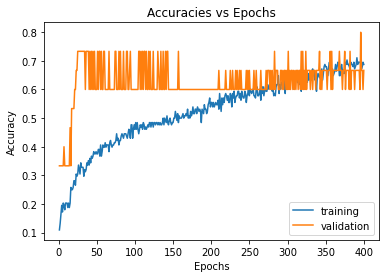

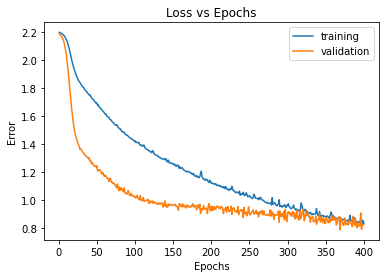

In [210]:
results(history, y_valid, model)

In [211]:
pred_baseline = model.evaluate(X_test,y_test)

1/1 [==============================] - 0s 358ms/step - loss: 1.3564 - accuracy: 0.4667


In [212]:
pred = model.predict(X_test)

In [213]:
pred_label = pred.argmax(axis=1)
actual_label = y_test.argmax(axis=1)

Confusion matrix, without normalization


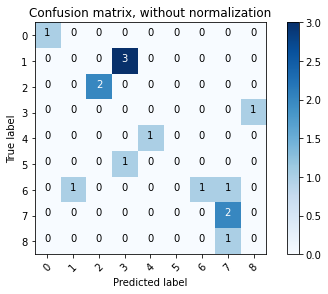

Normalized confusion matrix


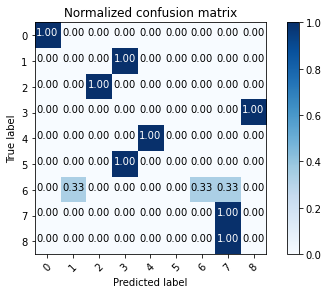

In [214]:
plot_confusion_matrix(pred_label, actual_label)

### Raw Waveforms Combined Augmentation

In [17]:
metadata=pd.read_csv("C:\\Users\\dario\\OneDrive\\Documenti\\Thesis_PC\\orthoptera\\metadata_augmented.csv")
metadata.head()

,id,species
0,Chorthippus biguttulus (1).wav,0
1,Chorthippus biguttulus (2).wav,0
2,Chorthippus biguttulus (3).wav,0
3,Chorthippus biguttulus (4).wav,0
4,Chorthippus biguttulus (5).wav,0


In [18]:
# create dataset with duration = 5 to get same size

D = [] # Dataset

for row in metadata.itertuples():
    y, sr = librosa.load("C:\\Users\\dario\\OneDrive\\Documenti\\Thesis_PC\\augmentation\\" + row.id, duration = 5, sr = 44100)  
    D.append( (y, row.species) )

In [19]:
import random
from keras import utils as np_utils

dataset = D
random.Random(100).shuffle(dataset)

train = dataset[:1132]
valid = dataset[1132:1277]
test = dataset[1277:]

X_train, y_train = zip(*train)
X_valid, y_valid = zip(*valid)
X_test, y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (220500, 1) ) for x in X_train])
X_valid = np.array([x.reshape( (220500, 1) ) for x in X_valid])
X_test = np.array([x.reshape( (220500, 1) ) for x in X_test])

# One-Hot encoding for classes
y_train = np.array(keras.utils.np_utils.to_categorical(y_train, 9))
y_valid = np.array(keras.utils.np_utils.to_categorical(y_valid, 9))
y_test = np.array(keras.utils.np_utils.to_categorical(y_test, 9))

In [20]:
# model
model = Sequential()

model.add(layers.Input((220500, 1)))
model.add(layers.Conv1D(8, kernel_size=5)) #, kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
          
model.add(layers.Conv1D(16, kernel_size=5)) #, kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))

model.add(layers.MaxPooling1D(2))
model.add(layers.MaxPooling1D(2))
model.add(layers.MaxPooling1D(2))

model.add(Dense(16)) #8
model.add(Lambda(lambda x: K.mean(x, axis=1))) # maybe change to 0
model.add(Dense(9, activation='softmax'))

#opt = tf.keras.optimizers.Adam(learning_rate=0.01)      
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 220496, 8)         48        
                                                                 
 activation_6 (Activation)   (None, 220496, 8)         0         
                                                                 
 conv1d_7 (Conv1D)           (None, 220492, 16)        656       
                                                                 
 activation_7 (Activation)   (None, 220492, 16)        0         
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 110246, 16)       0         
 1D)                                                             
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 55123, 16)        0         
 g1D)                                                 

In [67]:
history = model.fit(X_train, y_train, batch_size=10, epochs=100, validation_data=(X_valid, y_valid), verbose=1)

Epoch 1/100
114/114 [==============================] - 110s 958ms/step - loss: 2.1811 - accuracy: 0.0954 - val_loss: 2.1321 - val_accuracy: 0.1793
Epoch 2/100
114/114 [==============================] - 109s 955ms/step - loss: 2.0397 - accuracy: 0.1882 - val_loss: 1.8731 - val_accuracy: 0.3379
Epoch 3/100
114/114 [==============================] - 109s 952ms/step - loss: 1.8468 - accuracy: 0.2765 - val_loss: 1.7487 - val_accuracy: 0.3655
Epoch 4/100
114/114 [==============================] - 110s 967ms/step - loss: 1.7462 - accuracy: 0.3171 - val_loss: 1.6852 - val_accuracy: 0.4069
Epoch 5/100
114/114 [==============================] - 108s 945ms/step - loss: 1.6801 - accuracy: 0.3481 - val_loss: 1.6293 - val_accuracy: 0.3862
Epoch 6/100
114/114 [==============================] - 108s 949ms/step - loss: 1.6343 - accuracy: 0.3542 - val_loss: 1.5744 - val_accuracy: 0.4414
Epoch 7/100
114/114 [==============================] - 109s 954ms/step - loss: 1.5752 - accuracy: 0.3852 - val_loss: 1

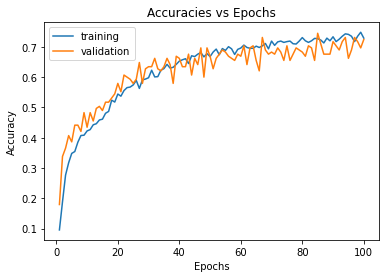

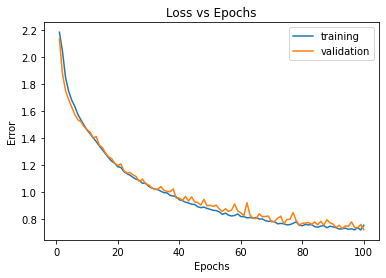

In [90]:
results(history, y_valid, model)

In [69]:
pred_baseline = model.evaluate(X_test,y_test)

5/5 [==============================] - 3s 573ms/step - loss: 0.6253 - accuracy: 0.7655


In [76]:
pred = model.predict(X_test)

In [85]:
pred_label = pred.argmax(axis=1)
actual_label = y_test.argmax(axis=1)

Confusion matrix, without normalization


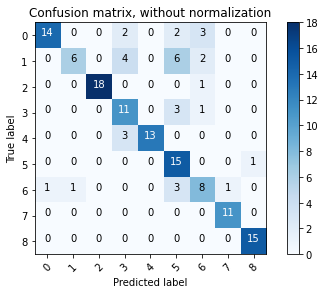

Normalized confusion matrix


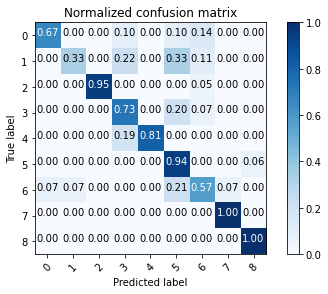

In [87]:
plot_confusion_matrix(pred_label, actual_label)